In [67]:
import seaborn as sns
from sklearn.model_selection import train_test_split
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, f1_score, classification_report, roc_curve, auc, confusion_matrix, roc_auc_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from sklearn.naive_bayes import GaussianNB
from imblearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import cross_validate
from sklearn.neural_network import MLPClassifier
from sklearn.utils.multiclass import unique_labels
from sklearn.tree import export_graphviz #plot tree
from sklearn.metrics import roc_curve, auc #for model evaluation
from sklearn.metrics import confusion_matrix #for model evaluation
import eli5 #for purmutation importance
from eli5.sklearn import PermutationImportance
import shap #for SHAP values
from IPython.display import display, HTML
from pdpbox import pdp, info_plots #for partial plots
import joblib, os
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.preprocessing import label_binarize



scoring = {'acc': 'accuracy',
           'prec_macro': 'precision_macro',
           'rec_macro': 'recall_macro',
           'f1_macro':'f1_macro'}


title = '156selected_156_1130'
KFOLD = 10
N_JOBS = 10


def mkdir(path):
    path = path.strip()
    path = path.rstrip("\\")
    isExists = os.path.exists(path)

    if not isExists:
        os.makedirs(path)
        return True
    else:
        return False


def preprocess(countpath, testsize = 0.2, randomstate = 1):
    x = pd.read_csv('%s' % countpath, index_col=0).T

    # get feature names
    featurenames = np.array(x.index)

    # get label names
    x = x.T
    y = list(np.array(x.index))
    label = sorted(list(set(y)), key = y.index)
    
    df = x
    df['target'] = y

    for classname in label:
        count_temp = len(df[df.target == classname])
        print("Proportion of family {0}: {1:.2f}%".format(classname, (count_temp / (len(df.target)) * 100)))


    y = df.target.values
    x= df.drop(['target'], axis=1)
    
    x = x.dropna(axis=1, how='any')  # drop all rows that have any NaN value
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = testsize, random_state = randomstate)

    return x_train, y_train, x_test, y_test, featurenames, label, df


def counting(label, y_train):
    counting = {}
    for i in label:
        count = 0
        for j in y_train:
            if i == j:
                count = count+1        
        counting[i] = count
    print(counting)
    
    return counting


def smote_dict(label, counting):
    dict = {}
    for i in label:
        if i == 'RF00168':
            dict[i] = counting[i] * 6
        elif counting[i] > 1000:
            dict[i] = counting[i]
        elif counting[i] > 700:
            dict[i] = counting[i] * 2
        elif counting[i] > 500:
            dict[i] = counting[i] * 3
        elif counting[i] > 200:
            dict[i] = counting[i] * 5
        else:
            dict[i] = counting[i] * 10
    print(dict)
    return dict


def calcu_metrix(scores):
    return (np.mean(scores['test_f1_macro']) * 0.6 + np.mean(scores['test_prec_macro'])*0.2 + np.mean(scores['test_rec_macro'])* 0.2)


def print_report(name, model, x_test, y_test):
    
    model_pred = model.predict(x_test)
    
    # f1 score
    print("f1 score of {0}: {1:.3f}".format(name, f1_score(y_test,model_pred, average = 'macro')))
    # 模型评估报告
    report = classification_report(y_test, model_pred, target_names= label, output_dict=True)
    
#     dataframe = pd.DataFrame(report).transpose()
#     dataframe.to_csv('./Prediction_output_%s/Classification_report/%s_%s.csv' % (title, title, name), index = False)

    print("Classification report of {0}: \n{1}".format(name, classification_report(y_test, model_pred,
                                            target_names= label, digits = 3)))

    
def addtwodimdict(dict, key_a, key_b, val): 
    if key_a in adic:
        dict[key_a].update({key_b: val})
    else:
        dict.update({key_a:{key_b: val}})


def save(model, model_name):
    joblib.dump(model, './Model/%s_%s.pkl' % (model_name, title))

    
def load(model_name):
    return joblib.load('./Model/%s_%s.pkl' % (model_name, title))


def export_con_matrix(model, model_name):
    pred = model.predict(x_test)
    confusion = pd.DataFrame(confusion_matrix(y_test, pred))
    mkdir('./Confusion_matrix/%s' % title)
    confusion.to_csv('./Confusion_matrix/%s/Confusion_matrix_%s_%s_%s.csv' % (title, model_name[0],model_name[1], title))
    return confusion


models_transfer = {
    'knn':'KNN',
    'knn_im':'KNN',
    'svm':'SVM',
    'svm_im':'SVM',
    'random':'Random Forest',
    'random_im':'Random Forest',
    'gb':'Gradient Boosting',
    'gb_im':'Gradient Boosting',
    'mlp':'MLP',
    'mlp_im':'MLP',
    'nb':'Naive Bayes',
    'nb_im':'Naive Bayes'
}


models_names = {
    'knn':'Balanced',
    'knn_im':'Imbalanced',
    'svm':'Balanced',
    'svm_im':'Imbalanced',
    'random':'Balanced',
    'random_im':'Imbalanced',
    'gb':'Balanced',
    'gb_im':'Imbalanced',
    'mlp':'Balanced',
    'mlp_im':'Imbalanced',
    'nb':'Balanced',
    'nb_im':'Imbalanced'
}

In [11]:
# KNN Model
def KNN(x_train, y_train, x_test, y_test, strategy):

    # try ro find best k value
    best = make_pipeline(SMOTE(random_state = 5, k_neighbors = 5), KNeighborsClassifier(n_neighbors=6))
    scores = cross_validate(best, x_train, y_train, scoring = scoring, cv = KFOLD, n_jobs=N_JOBS)
    best_scores = scores
    print(6)
    print(scores)
    best_metrix = calcu_metrix(scores)
    best.fit(x_train, y_train)

    scoreList = []
    scoreList.append(best.score(x_test, y_test))
    for i in range(8, 16, 2):
        knn2 = make_pipeline(SMOTE(random_state = 5, k_neighbors = 5, sampling_strategy = strategy), \
                             KNeighborsClassifier(n_neighbors=i)) # n_neighbors means 
        scores = cross_validate(knn2, x_train, y_train, scoring = scoring, cv = KFOLD, n_jobs=N_JOBS)
        temp_metrix = calcu_metrix(scores)
        print(i)
        print(scores)
        if temp_metrix > best_metrix:
            best = knn2
            best_scores = scores
        knn2.fit(x_train, y_train)
        scoreList.append(knn2.score(x_test, y_test))

    
    plt.plot(range(6, 16, 2), scoreList)
    plt.xticks(np.arange(6, 16, 2))
    plt.xlabel("K value")
    plt.ylabel("Score")
    plt.savefig("./Prediction_output_%s/knn_iteration.png" % title)
    plt.show()
    print("Maximum KNN Acuracy Score is {:.2f}%".format((max(scoreList)) * 100))
    
    
    print_report('knn', best, x_test, y_test)
    best_scores = pd.DataFrame(best_scores).transpose()
    best_scores.to_csv('./Prediction_output_%s/knn_cross_validation_score.csv' % title, index=True)

    return best

def KNN_im(x_train, y_train, x_test, y_test):

    # try ro find best k value
    best = KNeighborsClassifier(n_neighbors=6)
    scores = cross_validate(best, x_train, y_train, scoring = scoring, cv = KFOLD, n_jobs=N_JOBS)
    best_scores = scores
    print(6)
    print(scores)
    best_metrix = calcu_metrix(scores)
    best.fit(x_train, y_train)

    scoreList = []
    scoreList.append(best.score(x_test, y_test))
    for i in range(8, 16, 2):
        knn2 =KNeighborsClassifier(n_neighbors=i)  # n_neighbors means 
        scores = cross_validate(knn2, x_train, y_train, scoring = scoring, cv = KFOLD, n_jobs=N_JOBS)
        temp_metrix = calcu_metrix(scores)
        print(i)
        print(scores)
        if temp_metrix > best_metrix:
            best = knn2
            best_scores = scores
        knn2.fit(x_train, y_train)
        scoreList.append(knn2.score(x_test, y_test))
        

    plt.plot(range(6, 16, 2), scoreList)
    plt.xticks(np.arange(6, 16, 2))
    plt.xlabel("K value")
    plt.ylabel("Score")
    plt.savefig("./Prediction_output_%s/knn_im_iteration.png" % title)
    plt.show()

    print("Maximum KNN_im Acuracy Score is {:.2f}%".format((max(scoreList)) * 100))
    
    print_report('knn_im', best, x_test, y_test)
    best_scores = pd.DataFrame(best_scores).transpose()
    best_scores.to_csv('./Prediction_output_%s/knn_im_cross_validation_score.csv' % title, index=True)

 
    return best

In [18]:
def svm(x_train, y_train,x_test, y_test, strategy):
    
    best = make_pipeline(SMOTE(sampling_strategy = strategy), SVC(cache_size=4096, kernel='linear'))
    best_metrix = 0
    scoreList = []
    for i in ('poly', 'rbf'):
        svm = make_pipeline(SMOTE(sampling_strategy = strategy), \
                            SVC(cache_size=4096, kernel='%s' % i, probability = True, class_weight = 'balanced'))
        scores = cross_validate(svm, x_train, y_train, scoring = scoring, cv = 10, n_jobs=10)
        temp_metrix = calcu_metrix(scores)
        print(i)
        print(scores)
        if temp_metrix > best_metrix:
            best = svm
            best_scores = scores
        svm.fit(x_train, y_train)
        scoreList.append((i, svm.score(x_test, y_test)))
        
    print("Maximum kernel Score is {:.2f}%".format((max([x[1] for x in scoreList])) * 100))
    
    best_scores = pd.DataFrame(best_scores).transpose()
    best_scores.to_csv('./Prediction_output_%s/svm_cross_validation_score.csv' % title, index=True)
    print_report('svm', best, x_test, y_test)

    return best

def svm_im(x_train, y_train,x_test, y_test):

    best = SVC(cache_size=4096, kernel='linear')
    best_metrix = 0
    
    # try to find the best kernel
    scoreList = []
    for i in ('poly', 'rbf'):
        svm = SVC(cache_size=4096, kernel='%s' % i, probability = True)
        scores = cross_validate(svm, x_train, y_train, scoring = scoring, cv = 10, n_jobs=10)
        temp_metrix = calcu_metrix(scores)
        print(i)
        print(scores)
        if temp_metrix > best_metrix:
            best = svm
            best_scores = scores
        svm.fit(x_train, y_train)
        scoreList.append((i, svm.score(x_test, y_test)))


    plt.title('Various kernels of SVM algorithms')
    plt.plot([x[0] for x in scoreList], [x[1] for x in scoreList])
    plt.xticks([x[0] for x in scoreList])
    plt.xlabel("Kernel")
    plt.ylabel("Score")
    plt.savefig("./Prediction_output_%s/svm_im_kernel.png" % title)
    plt.show()
    print("Maximum kernel Score is {:.2f}%".format((max([x[1] for x in scoreList])) * 100))

    best_scores = pd.DataFrame(best_scores).transpose()
    best_scores.to_csv('./Prediction_output_%s/svm_im_cross_validation_score.csv' % title, index=True)
    print_report('svm_im', best, x_test, y_test)

    return best

In [19]:
def random_forest(x_train, y_train, x_test, y_test, strategy, class_weight = None):
    
    #使用网格搜索 查找最优参数
    
#     param_grid = [{'randomforestclassifier__n_estimators': [2000, 1000, 500],
#                'randomforestclassifier__max_features': [50, 30],
#                'randomforestclassifier__max_depth': [20, 15, 10]}]
    
    param_grid = [{'randomforestclassifier__n_estimators': [1000],
                   'randomforestclassifier__max_depth': [20]}]

    best = make_pipeline(SMOTE(sampling_strategy = strategy), \
                         RandomForestClassifier(n_jobs=20, n_estimators = 1000, \
                                                                    max_depth = 20, class_weight = class_weight))
#     grid_search = GridSearchCV(best, param_grid, cv=5, n_jobs=-1)
#     grid_search.fit(x_train, y_train)

#     best_scores = cross_validate(best, x_train, y_train, scoring = scoring, cv = 10, n_jobs=-1)
    
#     print(scores)
    best.fit(x_train, y_train)
    print("Test score: {:.2f}".format(best.score(x_test, y_test)))
    
#     best_scores = pd.DataFrame(best_scores).transpose()
#     best_scores.to_csv('./Prediction_output/svm_im_cross_validation_score.csv', index=True)
    print_report('random_forest', best, x_test, y_test)

    return best

def random_forest_im(x_train, y_train, x_test, y_test, class_weight = None):

    #使用网格搜索 查找最优参数
    
#     param_grid = [{'randomforestclassifier__n_estimators': [2000, 1000, 500],
#                'randomforestclassifier__max_features': [50, 30],
#                'randomforestclassifier__max_depth': [20, 15, 10]}]
    
    best_tested_param_grid = [{'randomforestclassifier__n_estimators': [1000],
                   'randomforestclassifier__max_depth': [20]}]

    best = RandomForestClassifier(n_jobs=20, n_estimators = 1000, max_depth = 20, class_weight = class_weight)
    best.fit(x_train, y_train)
#     grid_search = GridSearchCV(best, param_grid, cv=5, n_jobs=-1)
#     grid_search.fit(x_train, y_train)

#     scores = cross_validate(best, x_train, y_train, scoring = scoring, cv = 10, n_jobs=-1)
    
#     print(scores)
#     print("parameters: ", grid_search.best_params_)
    print("Test score: {:.2f}".format(best.score(x_test, y_test)))
    
#     best_scores = pd.DataFrame(best_scores).transpose()
#     best_scores.to_csv('./Prediction_output/random_forest_im_cross_validation_score.csv', index=True)
    print_report('random_forest_im', best, x_test, y_test)
    
    return best

In [20]:
def mlp(x_train, y_train, x_test, y_test, strategy):
    mlp = make_pipeline(SMOTE(random_state = 1, sampling_strategy = strategy), \
                        MLPClassifier(hidden_layer_sizes=(80, 80, 80), max_iter=200, alpha=0.0001,
                                                          solver='adam',verbose= 10, tol=0.000000001))
    mlp.fit(x_train, y_train)
    print("Accuracy of mlp model is {:.3f}".format(mlp.score(x_test, y_test)))
    proba = mlp.predict_proba(x_test)
    # log_proba = mlp.predict_log_proba(x_test)
    print(mlp.predict(x_test))
    pred_mlp = mlp.predict(x_test)
    print((pred_mlp == y_test).sum() / y_test.size)
    
    print_report('mlp', mlp, x_test, y_test)
    return mlp

def mlp_im(x_train, y_train, x_test, y_test):
    mlp_im = MLPClassifier(hidden_layer_sizes=(80, 80, 80), max_iter=200, alpha=0.0001,
                     solver='adam', verbose=10, tol=0.000000001)
    mlp_im.fit(x_train, y_train)
    print("Accuracy of mlp_im imbalance model is {:.3f}".format(mlp_im.score(x_test, y_test)))
    proba = mlp_im.predict_proba(x_test)
    # log_proba = mlp_im.predict_log_proba(x_test)
    print(mlp_im.predict(x_test))
    pred_mlp_im = mlp_im.predict(x_test)
    print((pred_mlp_im == y_test).sum() / y_test.size)

    print_report('mlp_im', mlp_im, x_test, y_test)
    return mlp_im

In [21]:
def naive_bayes(x_train, y_train, x_test, y_test, strategy):
    nb = make_pipeline(SMOTE(random_state = 5, sampling_strategy = strategy), GaussianNB(var_smoothing=1e-16))
    nb.fit(x_train, y_train)
#     scores = cross_validate(nb, x_train, y_train, scoring = scoring, cv = 10)
#     print(scores)
    print("Accuracy of Naive Bayes: {:.2f}%".format(nb.score(x_test,y_test)*100))

    print_report('nb', nb, x_test, y_test)
    
#     scores = pd.DataFrame(scores).transpose()
#     scores.to_csv('./Prediction_output/nb_cross_validation_score.csv', index=True)
    
    return nb

def naive_bayes_im(x_train, y_train, x_test, y_test):
    nb = GaussianNB(var_smoothing=1e-16)
    nb.fit(x_train, y_train)
#     scores = cross_validate(nb, x_train, y_train, scoring = scoring, cv = 10)
#     print(scores)
    print("Accuracy of Naive Bayes: {:.2f}%".format(nb.score(x_test, y_test)*100))

    print_report('nb_im', nb, x_test, y_test)
#     scores = pd.DataFrame(scores).transpose()
#     scores.to_csv('./Prediction_output/nb_cross_validation_score.csv', index=True)
    
    return nb

In [22]:
def gradient_boosting(x_train, y_train, x_test, y_test, strategy):


    # 网格搜索算法查询最优参数（n_estimators 树个数；learning_rate 学习率； max_depth 树深度 ）
    # params_gbrt = [{
    #     'gradientboostingclassifier__n_estimators':[500,1000,2000],
    #     'gradientboostingclassifier__learning_rate':[0.01,0.1,0.05],
    #     'gradientboostingclassifier__max_depth':[7, 9, 11]
    # }]

    params_gbrt = {
        'n_estimators':1000,
        'learning_rate':0.05,
        'max_depth': 15
    }

    # gbrt_grid = GridSearchCV(gbrt, params_gbrt, cv=5, n_jobs=10)
    # gbrt_grid.fit(x_train, y_train)
    # #gbrt.fit(x_train, y_train)

    # print('Report of gradient_boosting:\n')
    # print("Best cross-validation score: {:.2f}".format(gbrt_grid.best_score_))
    # print("Best parameters: ", gbrt_grid.best_params_)
    # print("Accuracy on training set:{:.3f}".format(gbrt_grid.score(x_train, y_train)))
    # print("Accuracy on test set:{:.3f}".format(gbrt_grid.score(x_test, y_test)))

    ## 使用gbrt的最优参数构建模型 并评估模型性能
    # best_params_gbrt = gbrt_grid.best_params_

    gbrt_model = make_pipeline(SMOTE(random_state = 1, sampling_strategy = dict), \
                              GradientBoostingClassifier(**params_gbrt))
    gbrt_model.fit(x_train, y_train)
    
    print("Accuracy on test set:{:.3f}".format(gbrt_model.score(x_test, y_test)))
    print_report('gb', gbrt_model, x_test, y_test)

    return gbrt_model

def gradient_boosting_im(x_train, y_train, x_test, y_test):
    
    params_gbrt = {
        'n_estimators':1000,
        'learning_rate':0.05,
        'max_depth': 15
    }

#     gbrt_grid = GridSearchCV(gbrt, params_gbrt, cv=5, n_jobs=5)
#     gbrt_grid.fit(x_train, y_train)
    #gbrt.fit(x_train, y_train)

#     print('Report of gradient_boosting:\n')
#     print("Best cross-validation score: {:.2f}".format(gbrt_grid.best_score_))
#     print("Best parameters: ", gbrt_grid.best_params_)
#     print("Accuracy on training set:{:.3f}".format(gbrt_grid.score(x_train, y_train)))
#     print("Accuracy on test set:{:.3f}".format(gbrt_grid.score(x_test, y_test)))

#     ## 使用gbrt的最优参数构建模型 并评估模型性能
#     best_params_gbrt = gbrt_grid.best_params_

    gbrt_model = GradientBoostingClassifier(**params_gbrt)
    gbrt_model.fit(x_train, y_train)
    
#     scores = cross_validate(gbrt_model, x_train, y_train, scoring = scoring, cv = 10, n_jobs=10)
    print("Accuracy on train set:{:.3f}".format(gbrt_model.score(x_test, y_test)))
    print("Accuracy on test set:{:.3f}".format(gbrt_model.score(x_test, y_test)))

    print_report('gb_im', gbrt_model, x_test, y_test)

    return gbrt_model    # 梯度提升回归树  GBRT

In [25]:
if __name__ == '__main__':
    countpath = './156_new_selected_156.csv'

    x_train, y_train, x_test, y_test, featurenames, label, dataframe = preprocess(countpath, 0.3, 3)
    
    
    mkdir('./Prediction_output_%s/Classification_report' % title)
    count = counting(label, y_train)
    dict = smote_dict(label, count)
   

Proportion of family RF00050: 7.48%
Proportion of family RF00059: 22.34%
Proportion of family RF00162: 7.67%
Proportion of family RF00167: 5.02%
Proportion of family RF00168: 2.11%
Proportion of family RF00174: 26.48%
Proportion of family RF00234: 1.70%
Proportion of family RF00380: 1.34%
Proportion of family RF00504: 13.13%
Proportion of family RF00521: 1.03%
Proportion of family RF00522: 0.72%
Proportion of family RF00634: 1.33%
Proportion of family RF01051: 6.30%
Proportion of family RF01054: 0.24%
Proportion of family RF01055: 1.87%
Proportion of family RF01057: 1.22%
{'RF00050': 827, 'RF00059': 2551, 'RF00162': 852, 'RF00167': 587, 'RF00168': 245, 'RF00174': 2993, 'RF00234': 181, 'RF00380': 152, 'RF00504': 1491, 'RF00521': 133, 'RF00522': 81, 'RF00634': 155, 'RF01051': 701, 'RF01054': 21, 'RF01055': 210, 'RF01057': 148}
{'RF00050': 1654, 'RF00059': 2551, 'RF00162': 1704, 'RF00167': 1761, 'RF00168': 1470, 'RF00174': 2993, 'RF00234': 1810, 'RF00380': 1520, 'RF00504': 1491, 'RF00521'

## KNN model test

knn
----------------------------------------------------------------
6
{'fit_time': array([4.43994713, 4.78112125, 4.9448688 , 4.68320704, 4.62062192,
       4.58889556, 4.61679506, 4.52378368, 4.62616992, 4.44306064]), 'score_time': array([54.84095383, 52.52633715, 48.94019985, 55.06800056, 53.2062552 ,
       55.56206155, 48.42211056, 53.33631349, 53.04119802, 55.47709036]), 'test_acc': array([0.90201225, 0.89094107, 0.88722467, 0.89673433, 0.88526037,
       0.8938992 , 0.88770999, 0.88928255, 0.8998227 , 0.90248227]), 'test_prec_macro': array([0.77892734, 0.81275415, 0.78803293, 0.79025638, 0.76280762,
       0.76166472, 0.77832317, 0.75858734, 0.79454169, 0.80219922]), 'test_rec_macro': array([0.88318647, 0.91865683, 0.90108608, 0.916483  , 0.88578968,
       0.90229232, 0.91011123, 0.88785084, 0.92617285, 0.93118056]), 'test_f1_macro': array([0.81666056, 0.85438993, 0.83218976, 0.8389666 , 0.80872004,
       0.81019102, 0.82848147, 0.80377286, 0.84242567, 0.85308986])}
8
{'fit_ti

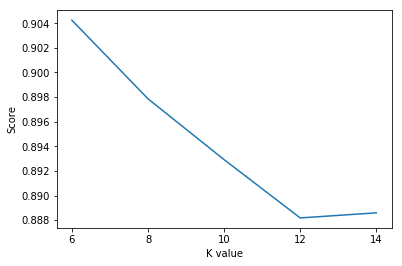

Maximum KNN Acuracy Score is 90.42%
f1 score of knn: 0.856
Classification report of knn: 
              precision    recall  f1-score   support

     RF00050      0.849     0.953     0.898       384
     RF00059      0.986     0.944     0.964      1065
     RF00162      0.882     0.943     0.912       389
     RF00167      0.829     0.881     0.854       226
     RF00168      0.484     0.802     0.604        96
     RF00174      0.992     0.814     0.894      1293
     RF00234      0.618     0.862     0.720        94
     RF00380      0.596     0.954     0.734        65
     RF00504      0.987     0.937     0.961       634
     RF00521      0.919     1.000     0.958        34
     RF00522      0.972     1.000     0.986        35
     RF00634      0.759     0.984     0.857        61
     RF01051      0.957     0.987     0.972       319
     RF01054      0.720     1.000     0.837        18
     RF01055      0.647     0.828     0.726        93
     RF01057      0.716     0.960     0.821  

In [55]:
print('knn')
print('----------------------------------------------------------------')
knn = KNN(x_train, y_train, x_test, y_test,'not majority')
save(knn, 'knn')

knn_im
----------------------------------------------------------------
6
{'fit_time': array([0.2709744 , 0.12616825, 0.16589332, 0.1597085 , 0.27166176,
       0.1643424 , 0.27999187, 0.14076781, 0.14701438, 0.14739299]), 'score_time': array([18.20588279, 18.06362319, 18.4332068 , 16.95914745, 16.91894531,
       16.71238685, 18.34007239, 15.81618762, 16.51496434, 17.34400582]), 'test_acc': array([0.92388451, 0.92172383, 0.92422907, 0.92850838, 0.92497793,
       0.93810787, 0.92661362, 0.914969  , 0.93085106, 0.94148936]), 'test_prec_macro': array([0.84473568, 0.91067008, 0.91484784, 0.91872257, 0.85807856,
       0.86942158, 0.86542127, 0.88985317, 0.92591954, 0.88804023]), 'test_rec_macro': array([0.81551748, 0.83969018, 0.84481853, 0.87742724, 0.8098496 ,
       0.80791442, 0.81500838, 0.80383561, 0.87099401, 0.8167626 ]), 'test_f1_macro': array([0.82651434, 0.86416255, 0.86840475, 0.89312472, 0.82741994,
       0.82894035, 0.83354233, 0.82628707, 0.89165649, 0.84211783])}
8
{'fit

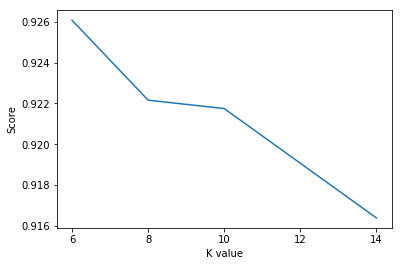

Maximum KNN_im Acuracy Score is 92.61%
f1 score of knn_im: 0.848
Classification report of knn_im: 
              precision    recall  f1-score   support

     RF00050      0.903     0.943     0.922       384
     RF00059      0.933     0.983     0.957      1065
     RF00162      0.888     0.941     0.914       389
     RF00167      0.829     0.858     0.843       226
     RF00168      0.775     0.573     0.659        96
     RF00174      0.938     0.940     0.939      1293
     RF00234      0.859     0.585     0.696        94
     RF00380      0.806     0.831     0.818        65
     RF00504      0.962     0.948     0.955       634
     RF00521      0.941     0.941     0.941        34
     RF00522      0.946     1.000     0.972        35
     RF00634      0.902     0.902     0.902        61
     RF01051      0.953     0.947     0.950       319
     RF01054      1.000     0.333     0.500        18
     RF01055      0.919     0.613     0.735        93
     RF01057      0.894     0.840   

In [56]:
print('knn_im')
print('----------------------------------------------------------------')
knn_im = KNN_im(x_train, y_train, x_test, y_test)
save(knn_im, 'knn_im')

## SVM model test

In [52]:
print('svm')
print('----------------------------------------------------------------')
svm = svm(x_train, y_train, x_test, y_test, 'not majority')
save(svm, 'svm')

svm
----------------------------------------------------------------
poly
{'fit_time': array([642.27426791, 652.04786468, 621.11930418, 638.08146596,
       630.23782349, 645.51847196, 722.93994546, 655.06188917,
       642.29706812, 677.10336065]), 'score_time': array([17.57484412, 17.99469352, 20.07663941, 18.33270669, 20.02912831,
       17.54042912,  3.78045535, 17.79686999, 21.96779585, 20.01897287]), 'test_acc': array([0.96937883, 0.96745822, 0.96475771, 0.96822595, 0.97616946,
       0.96816976, 0.97259063, 0.96102746, 0.97429078, 0.97251773]), 'test_prec_macro': array([0.94489283, 0.94528599, 0.92612005, 0.95763842, 0.95399888,
       0.94504219, 0.96353216, 0.92605608, 0.96328822, 0.94986504]), 'test_rec_macro': array([0.92756421, 0.95111763, 0.95026397, 0.9573681 , 0.94279884,
       0.93841358, 0.95513375, 0.93852314, 0.94243055, 0.95916469]), 'test_f1_macro': array([0.93197647, 0.94651797, 0.93720699, 0.95419156, 0.94237525,
       0.94059927, 0.95820379, 0.93112476, 0.9512

svm_im
----------------------------------------------------------------
poly
{'fit_time': array([120.56179404, 125.20292783, 123.80568314, 123.13318038,
       119.1363852 , 119.7047894 , 123.69413352, 122.30617094,
       121.00287843, 120.85168004]), 'score_time': array([2.31619382, 2.68065572, 2.62282681, 2.53460383, 2.28441644,
       2.27244902, 2.57486153, 2.45555878, 2.33087659, 2.38074851]), 'test_acc': array([0.9720035 , 0.97273527, 0.969163  , 0.97087379, 0.98058252,
       0.96993811, 0.9734748 , 0.96368468, 0.97429078, 0.97251773]), 'test_prec_macro': array([0.94650157, 0.95018337, 0.93561525, 0.95948595, 0.95831792,
       0.95114727, 0.96522667, 0.93111813, 0.95887257, 0.95301863]), 'test_rec_macro': array([0.93743263, 0.95998477, 0.95391279, 0.96319664, 0.94765116,
       0.94294512, 0.95534278, 0.94057145, 0.94569374, 0.96034813]), 'test_f1_macro': array([0.93876309, 0.95399365, 0.94395273, 0.95860256, 0.94723283,
       0.94557795, 0.95924342, 0.93498049, 0.95078247, 0

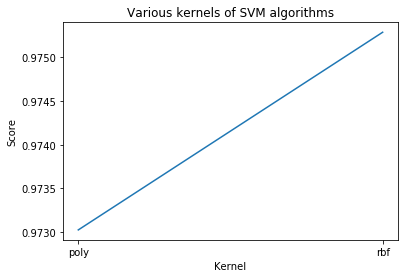

Maximum kernel Score is 97.53%
f1 score of svm_im: 0.955
Classification report of svm_im: 
              precision    recall  f1-score   support

     RF00050      0.995     0.958     0.976       384
     RF00059      0.991     0.993     0.992      1065
     RF00162      0.992     0.982     0.987       389
     RF00167      0.932     0.907     0.919       226
     RF00168      0.794     0.802     0.798        96
     RF00174      0.962     0.992     0.977      1293
     RF00234      0.988     0.840     0.908        94
     RF00380      0.968     0.923     0.945        65
     RF00504      0.995     0.995     0.995       634
     RF00521      1.000     0.971     0.985        34
     RF00522      0.972     1.000     0.986        35
     RF00634      0.967     0.967     0.967        61
     RF01051      0.975     0.991     0.983       319
     RF01054      1.000     0.889     0.941        18
     RF01055      0.977     0.925     0.950        93
     RF01057      0.980     0.960     0.970 

In [51]:
print('svm_im')
print('----------------------------------------------------------------')
svm_im = svm_im(x_train, y_train, x_test, y_test)
save(svm_im, 'svm_im')

## Random forest test

In [449]:
print('random forest')
print('----------------------------------------------------------------')
random = random_forest(x_train, y_train, x_test, y_test, dict)
save(random, 'random')

random forest
----------------------------------------------------------------
Test score: 0.98
f1 score of random_forest: 0.974
Classification report of random_forest: 
              precision    recall  f1-score   support

     RF00050      0.997     0.977     0.987       384
     RF00059      0.993     0.998     0.996      1065
     RF00162      0.982     0.985     0.983       389
     RF00167      0.935     0.889     0.912       226
     RF00168      0.761     0.865     0.810        96
     RF00174      0.990     0.994     0.992      1293
     RF00234      1.000     1.000     1.000        94
     RF00380      0.985     0.985     0.985        65
     RF00504      0.995     0.994     0.994       634
     RF00521      1.000     1.000     1.000        34
     RF00522      0.972     1.000     0.986        35
     RF00634      0.984     0.984     0.984        61
     RF01051      0.991     0.997     0.994       319
     RF01054      1.000     1.000     1.000        18
     RF01055      1

In [49]:
print('random_forest_im')
print('----------------------------------------------------------------')
random_im = random_forest_im(x_train, y_train, x_test, y_test)
save(random_im, 'random_im')

random_forest_im
----------------------------------------------------------------
Test score: 0.98
f1 score of random_forest_im: 0.945
Classification report of random_forest_im: 
              precision    recall  f1-score   support

     RF00050      0.989     0.979     0.984       384
     RF00059      0.991     0.998     0.994      1065
     RF00162      0.970     0.982     0.976       389
     RF00167      0.907     0.912     0.909       226
     RF00168      0.796     0.771     0.783        96
     RF00174      0.981     0.995     0.988      1293
     RF00234      1.000     0.957     0.978        94
     RF00380      0.982     0.862     0.918        65
     RF00504      0.989     0.995     0.992       634
     RF00521      1.000     1.000     1.000        34
     RF00522      1.000     1.000     1.000        35
     RF00634      1.000     0.951     0.975        61
     RF01051      0.981     0.997     0.989       319
     RF01054      1.000     0.556     0.714        18
     RF010

## Gradient Boosting

In [48]:
gb = gradient_boosting(x_train, y_train, x_test, y_test, dict)
save(gb, 'gb')

Accuracy on test set:0.958
f1 score of gb: 0.904
Classification report of gb: 
              precision    recall  f1-score   support

     RF00050      0.986     0.932     0.959       384
     RF00059      0.987     0.993     0.990      1065
     RF00162      0.867     0.956     0.910       389
     RF00167      0.881     0.885     0.883       226
     RF00168      0.739     0.708     0.723        96
     RF00174      0.967     0.987     0.977      1293
     RF00234      0.979     0.979     0.979        94
     RF00380      0.869     0.815     0.841        65
     RF00504      0.990     0.983     0.987       634
     RF00521      0.861     0.912     0.886        34
     RF00522      1.000     0.943     0.971        35
     RF00634      0.897     0.852     0.874        61
     RF01051      0.972     0.972     0.972       319
     RF01054      1.000     0.556     0.714        18
     RF01055      1.000     0.731     0.845        93
     RF01057      1.000     0.920     0.958        50

 

In [47]:
gb_im = gradient_boosting_im(x_train, y_train, x_test, y_test)
save(gb_im, 'gb_im')

Accuracy on train set:0.952
Accuracy on test set:0.952
f1 score of gb_im: 0.892
Classification report of gb_im: 
              precision    recall  f1-score   support

     RF00050      0.992     0.930     0.960       384
     RF00059      0.982     0.997     0.990      1065
     RF00162      0.984     0.949     0.966       389
     RF00167      0.895     0.872     0.883       226
     RF00168      0.784     0.604     0.682        96
     RF00174      0.960     0.994     0.976      1293
     RF00234      0.989     0.968     0.978        94
     RF00380      0.902     0.569     0.698        65
     RF00504      0.880     0.994     0.933       634
     RF00521      0.966     0.824     0.889        34
     RF00522      0.967     0.829     0.892        35
     RF00634      0.980     0.803     0.883        61
     RF01051      0.968     0.944     0.956       319
     RF01054      0.727     0.889     0.800        18
     RF01055      0.971     0.731     0.834        93
     RF01057      1.00

## MLP

In [45]:
mlp = mlp(x_train, y_train, x_test, y_test, dict)
save(mlp, 'mlp')

Iteration 13, loss = 0.00522025
Iteration 14, loss = 0.00388803
Iteration 15, loss = 0.00278992
Iteration 16, loss = 0.00146109
Iteration 17, loss = 0.00115895
Iteration 18, loss = 0.00106251
Iteration 19, loss = 0.00246342
Iteration 20, loss = 0.01460089
Iteration 21, loss = 0.00331203
Iteration 22, loss = 0.00097880
Iteration 23, loss = 0.00056183
Iteration 24, loss = 0.00045352
Iteration 25, loss = 0.00040291
Iteration 26, loss = 0.00036746
Iteration 27, loss = 0.00032568
Iteration 28, loss = 0.00030229
Iteration 29, loss = 0.00027801
Iteration 30, loss = 0.00026383
Iteration 31, loss = 0.00024465
Iteration 32, loss = 0.00023237
Iteration 33, loss = 0.00021995
Iteration 34, loss = 0.00021005
Iteration 35, loss = 0.00020012
Iteration 36, loss = 0.00019460
Iteration 37, loss = 0.00018810
Iteration 38, loss = 0.00018144
Iteration 39, loss = 0.00017416
Iteration 40, loss = 0.00016910
Iteration 41, loss = 0.00016618
Iteration 42, loss = 0.00016074
Iteration 43, loss = 0.00015807
Iteratio

In [46]:
mlp_im = mlp_im(x_train, y_train, x_test, y_test)
save(mlp_im, 'mlp_im')

Iteration 1, loss = 1.47405874
Iteration 2, loss = 0.37864528
Iteration 3, loss = 0.17034583
Iteration 4, loss = 0.09903850
Iteration 5, loss = 0.07487691
Iteration 6, loss = 0.05819773
Iteration 7, loss = 0.04633099
Iteration 8, loss = 0.03873211
Iteration 9, loss = 0.03509532
Iteration 10, loss = 0.02887242
Iteration 11, loss = 0.02533878
Iteration 12, loss = 0.02202773
Iteration 13, loss = 0.01988704
Iteration 14, loss = 0.01804913
Iteration 15, loss = 0.02028243
Iteration 16, loss = 0.01651955
Iteration 17, loss = 0.01608278
Iteration 18, loss = 0.01372465
Iteration 19, loss = 0.01288617
Iteration 20, loss = 0.01099862
Iteration 21, loss = 0.00917824
Iteration 22, loss = 0.00877432
Iteration 23, loss = 0.00807995
Iteration 24, loss = 0.00715767
Iteration 25, loss = 0.00989943
Iteration 26, loss = 0.00862901
Iteration 27, loss = 0.00455140
Iteration 28, loss = 0.00380310
Iteration 29, loss = 0.00312410
Iteration 30, loss = 0.00329690
Iteration 31, loss = 0.00261298
Iteration 32, los

In [ ]:
print_report('mlp_im_test', mlp_im, x_train, y_train)

## NB test

In [57]:
print('nb')
print('-------------------------------------------------------')
nb = naive_bayes(x_train, y_train, x_test, y_test, dict)
save(nb, 'nb')

nb
-------------------------------------------------------
Accuracy of Naive Bayes: 89.64%
f1 score of nb: 0.771
Classification report of nb: 
              precision    recall  f1-score   support

     RF00050      0.980     0.896     0.936       384
     RF00059      0.993     0.958     0.975      1065
     RF00162      0.968     0.856     0.909       389
     RF00167      0.893     0.668     0.765       226
     RF00168      0.478     0.896     0.623        96
     RF00174      0.926     0.924     0.925      1293
     RF00234      0.851     0.915     0.882        94
     RF00380      0.563     0.892     0.690        65
     RF00504      0.988     0.909     0.947       634
     RF00521      0.313     0.912     0.466        34
     RF00522      0.742     0.657     0.697        35
     RF00634      0.495     0.885     0.635        61
     RF01051      0.989     0.834     0.905       319
     RF01054      0.455     0.556     0.500        18
     RF01055      0.760     0.817     0.788   

In [58]:
print('nb_im')
print('-------------------------------------------------------')
nb_im = naive_bayes_im(x_train, y_train, x_test, y_test)
save(nb_im, 'nb_im')

nb_im
-------------------------------------------------------
Accuracy of Naive Bayes: 84.43%
f1 score of nb_im: 0.705
Classification report of nb_im: 
              precision    recall  f1-score   support

     RF00050      0.985     0.870     0.924       384
     RF00059      1.000     0.935     0.967      1065
     RF00162      0.976     0.743     0.844       389
     RF00167      0.943     0.664     0.779       226
     RF00168      0.455     0.833     0.588        96
     RF00174      0.962     0.866     0.912      1293
     RF00234      0.712     0.894     0.792        94
     RF00380      0.453     0.969     0.618        65
     RF00504      0.996     0.825     0.903       634
     RF00521      0.136     0.912     0.237        34
     RF00522      0.719     0.657     0.687        35
     RF00634      0.244     0.885     0.383        61
     RF01051      0.987     0.690     0.812       319
     RF01054      0.455     0.556     0.500        18
     RF01055      0.782     0.849    

## Three methods comparison

In [168]:
best = make_pipeline(SMOTE(random_state = 5), KNeighborsClassifier(n_neighbors=10))
scores = cross_validate(best, x_train, y_train, scoring = scoring, cv = 5, n_jobs=10)
print(scores)
best.fit(x_train, y_train)
best.score(x_test, y_test)
best_pred = best.predict(x_test)
# f1 score
print("f1 score of best: {:.2f}".format(f1_score(y_test,best_pred, average = 'macro')))
# 模型评估报告
print("Classification report of best: \n{}".format(classification_report(y_test, best_pred,
                                        target_names= label)))
best_proba = best.predict_proba(x_test)

{'fit_time': array([1.36815619, 1.38522267, 1.27516413, 1.46671844, 1.39341235]), 'score_time': array([65.77883387, 66.15830994, 64.95893312, 67.77423406, 66.04027724]), 'test_precision_macro': array([0.45819163, 0.48098308, 0.45682151, 0.47233651, 0.47222897]), 'test_recall_macro': array([0.69405591, 0.69335485, 0.67254681, 0.7193012 , 0.69062105]), 'test_f1_macro': array([0.46983322, 0.4947362 , 0.46601983, 0.49063489, 0.4851479 ])}
f1 score of best: 0.50
Classification report of best: 
              precision    recall  f1-score   support

     RF00050       0.62      0.79      0.69       359
     RF00059       0.95      0.43      0.59      1083
     RF00162       0.44      0.80      0.57       365
     RF00167       0.54      0.73      0.62       244
     RF00168       0.14      0.66      0.23        88
     RF00174       1.00      0.33      0.49      1277
     RF00234       0.25      0.71      0.37        90
     RF00380       0.20      0.79      0.32        63
     RF00504       

In [170]:
best2 = KNeighborsClassifier(n_neighbors=16)
scores2 = cross_validate(best2, x_train, y_train, scoring = scoring, cv = 5, n_jobs=10)
print(scores2)
best2.fit(x_train, y_train)
best2.score(x_test, y_test)
best2_pred = best2.predict(x_test)
# f1 score
print("f1 score of best3: {:.2f}".format(f1_score(y_test,best2_pred, average = 'macro')))
# 模型评估报告
print("Classification report of best2: \n{}".format(classification_report(y_test, best2_pred,
                                        target_names= label)))
best2_proba = best2.predict_proba(x_test)

{'fit_time': array([0.04368973, 0.04368138, 0.04063821, 0.04307175, 0.04468369]), 'score_time': array([11.63832211, 11.69619298, 12.09875536, 11.89288187, 11.96761632]), 'test_precision_macro': array([0.76222982, 0.77800996, 0.71748333, 0.7782801 , 0.79469287]), 'test_recall_macro': array([0.51248768, 0.5246983 , 0.50299728, 0.52320519, 0.49453976]), 'test_f1_macro': array([0.5736022 , 0.57565019, 0.55515465, 0.5859372 , 0.55578544])}
f1 score of best3: 0.60
Classification report of best2: 
              precision    recall  f1-score   support

     RF00050       0.83      0.78      0.81       359
     RF00059       0.79      0.92      0.85      1083
     RF00162       0.65      0.74      0.69       365
     RF00167       0.86      0.59      0.70       244
     RF00168       0.57      0.48      0.52        88
     RF00174       0.88      0.87      0.88      1277
     RF00234       0.80      0.27      0.40        90
     RF00380       0.79      0.48      0.59        63
     RF00504     

In [171]:
over_samples_train = SMOTEENN(random_state=5, n_jobs=5)
x_train_s, y_train_s = over_samples_train.fit_sample(x_train, y_train)
best3 = KNeighborsClassifier(n_neighbors=16)
scores3 = cross_validate(best3, x_train_s, y_train_s, scoring = scoring, cv = 5, n_jobs=10)
print(scores3)
best3.fit(x_train_s, y_train_s)
best3.score(x_test, y_test)

best3_pred = best3.predict(x_test)
# f1 score
print("f1 score of best3: {:.2f}".format(f1_score(y_test,best3_pred, average = 'macro')))
# 模型评估报告
print("Classification report of best3: \n{}".format(classification_report(y_test, best3_pred,
                                        target_names= label)))
best3_proba = best3.predict_proba(x_test)

{'fit_time': array([0.22312522, 0.29851818, 0.29342937, 0.18135238, 0.28857732]), 'score_time': array([168.14797163, 165.46073842, 166.19052601, 162.7279706 ,
       163.33171201]), 'test_precision_macro': array([0.95304545, 0.96063604, 0.95937588, 0.9568318 , 0.95625031]), 'test_recall_macro': array([0.91273627, 0.92393875, 0.91939974, 0.90468659, 0.90314451]), 'test_f1_macro': array([0.92442428, 0.93549652, 0.93110554, 0.91621002, 0.91123336])}
f1 score of best3: 0.46
Classification report of best3: 
              precision    recall  f1-score   support

     RF00050       0.55      0.79      0.65       359
     RF00059       0.98      0.26      0.41      1083
     RF00162       0.40      0.80      0.53       365
     RF00167       0.50      0.72      0.59       244
     RF00168       0.11      0.66      0.19        88
     RF00174       1.00      0.17      0.30      1277
     RF00234       0.24      0.73      0.36        90
     RF00380       0.17      0.78      0.28        63
     